<a href="https://colab.research.google.com/github/sujith2303/ML_From_Scratch/blob/main/GenAI%20Trainings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normal + GPU optimized Code
1. RoPE    --> Done
2. ADAM optimizer
3. MLA + KV cache, kv cache in attention, linear layers
4. Flash Attention
5. Cuda basics
6. Diffusion models
7. tokenizer implementations
8. WithRes and without Res  --> Done
9. ResNet vs deepseek mhc (manifold constrained hyperconnections)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
## plot RoPE for different values and see the convergence rule
## compare sinusoidal vs RoPE
# even_positions = x[...,:,0::2]
# odd_positions  = x[...,:,1::2]

class RoPE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.theta_factor = kwargs.get("theta_factor",10_000)


    def forward(self, x):
        b, s, d      = x.shape  ## b * s *d
        device       = x.device

        pos          = torch.arange(s).unsqueeze(1)
        i            = torch.arange(d//2).unsqueeze(0)
        angles       = pos/ (self.theta_factor ** (2*i/d))

        x[...,:,0::2],x[...,:,1::2] = x[...,:,0::2] * torch.cos(angles) - x[...,:,1::2] * torch.sin(angles),x[...,:,0::2] * torch.sin(angles) + x[...,:,1::2] * torch.cos(angles)

        return x


In [ ]:
class RoPE(nn.Module):
    def __init__(self, dim, theta_factor=10_000.0):
        super().__init__()
        self.dim = dim
        self.theta_factor = theta_factor

        # Precompute frequencies: [1, theta^{-2/d}, theta^{-4/d}, ..., theta^{-(d-2)/d}]
        inv_freq = 1.0 / (theta_factor ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))
        self.register_buffer("inv_freq", inv_freq)  # Shape: (dim//2,)

    def forward(self, x):
        # x: [batch, seq_len, dim]
        b, s, d = x.shape
        device = x.device

        assert d == self.dim, f"Input dimension {d} doesn't match RoPE dim {self.dim}"

        # Create position indices: [0, 1, ..., s-1] -> (s, 1)
        pos = torch.arange(s, device=device).unsqueeze(1)  # (s, 1)

        # Angles: pos * inv_freq -> (s, dim//2)
        angles = pos * self.inv_freq  # (s, dim//2)

        # Expand for sin/cos application
        cos_angles = angles.cos().unsqueeze(0)  # (1, s, dim//2)
        sin_angles = angles.sin().unsqueeze(0)  # (1, s, dim//2)

        # Split x into even and odd parts
        x_even = x[..., 0::2]   # (b, s, dim//2)
        x_odd  = x[..., 1::2]   # (b, s, dim//2)

        # Apply rotation: [x_even * cos - x_odd * sin, x_even * sin + x_odd * cos]
        x_rotated_even =  x_even * cos_angles - x_odd * sin_angles
        x_rotated_odd  =  x_even * sin_angles + x_odd * cos_angles

        # Interleave back
        x_rotated = torch.stack((x_rotated_even, x_rotated_odd), dim=-1)  # (b, s, dim//2, 2)
        x_rotated = x_rotated.flatten(-2)  # (b, s, dim)

        return x_rotated

In [ ]:
x = torch.randn(1,1_00_000,864)
r = RoPE(864)

In [ ]:
import time
a = time.time()
r(x)
print(time.time()-a)

2.110459566116333


In [ ]:
r(x)

tensor([[[ 0.0910, -0.7834,  1.4016,  ..., -0.6982, -0.1647,  0.0948],
         [-1.2312,  0.8008,  0.8015,  ...,  0.3385, -0.6373, -1.4966],
         [ 0.9750, -1.3813,  0.7346,  ...,  0.1699,  1.1279,  0.6638],
         ...,
         [-0.4958,  0.0198, -1.5695,  ...,  0.1597,  0.7557, -0.4927],
         [-0.2588, -0.0762,  0.6890,  ...,  0.9600,  0.4266,  0.9757],
         [ 0.0515, -3.4495,  0.6556,  ..., -0.2080,  0.1829, -0.7769]]])

### RoPE vs Sinusoidal vs Learned Embeddings (YaRN for Long contexts)

In [ ]:
## Create text data and embedding model
## Text --> Embedding + Sinusoidal/ RoPE/ Learned --> Model Trains --> Context increase from 100 --> 500 --> 1000 --> 10000

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self,
                 theta_factor = 10000):
        super().__init__()
        self.theta_factor = theta_factor

    def forward(self, x):
        b, s, d = x.shape
        i = torch.arange(d//2).unsqueeze(0)
        pos = torch.arange(s).unsqueeze(1)
        angles = pos/(self.theta_factor ** (2*i/d))

        embeddings = torch.empty((b, s, d))

        embeddings[:,:,0::2] = x[:,:,0::2] +  torch.cos(angles).unsqueeze(0)
        embeddings[:,:,1::2] = x[:,:,1::2] +  torch.sin(angles).unsqueeze(0)

        return embeddings,angles,pos,i

In [ ]:
S = SinusoidalEmbedding()
x = torch.rand(2,6,10)
x

tensor([[[0.5399, 0.1982, 0.8386, 0.1907, 0.3038, 0.2782, 0.6627, 0.5413,
          0.7768, 0.4022],
         [0.3375, 0.1626, 0.9499, 0.1846, 0.4193, 0.0053, 0.7462, 0.7295,
          0.2029, 0.8529],
         [0.8845, 0.9717, 0.7796, 0.8331, 0.5097, 0.2973, 0.8898, 0.0146,
          0.4261, 0.2187],
         [0.5518, 0.2542, 0.5690, 0.1879, 0.9493, 0.0944, 0.0132, 0.8707,
          0.5737, 0.9477],
         [0.8910, 0.6370, 0.5168, 0.3320, 0.0311, 0.1730, 0.1376, 0.1222,
          0.9710, 0.1581],
         [0.6566, 0.6751, 0.8784, 0.1676, 0.8431, 0.2316, 0.7018, 0.8514,
          0.2230, 0.7496]],

        [[0.4525, 0.7437, 0.3400, 0.5353, 0.3563, 0.5317, 0.3854, 0.6134,
          0.2965, 0.7961],
         [0.8386, 0.8395, 0.6840, 0.2220, 0.4708, 0.0563, 0.4287, 0.0946,
          0.7430, 0.5691],
         [0.5136, 0.8941, 0.1175, 0.9616, 0.3742, 0.7502, 0.9746, 0.3868,
          0.1396, 0.4008],
         [0.2053, 0.3471, 0.4124, 0.9847, 0.8782, 0.4507, 0.2311, 0.4722,
          0.103

In [ ]:
S(x)

## Adam Optimizer

## MLA

In [ ]:
### MLA , MHA

# DeepResNets vs Normal network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Hyperparameters
input_size = 784 # 28x28 for MNIST
hidden_size = 784 # Using a hidden size equal to input size for simplicity
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# 3. MNIST dataset loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image or numpy.ndarray to FloatTensor and scales values to [0, 1]
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize with mean and std dev for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 4. Neural Network model (without residual connections)
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_intermediate_blocks=4):
        super(NeuralNet, self).__init__()
        self.input_dim = input_dim
        layers = []
        # First layer: input_dim -> hidden_dim
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        # Intermediate layers: hidden_dim -> hidden_dim
        for _ in range(num_intermediate_blocks):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim) # Flatten the image
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

# ResNet model (with simple residual connections)
class ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=5): # num_blocks total linear layers
        super(ResNet, self).__init__()
        self.input_dim = input_dim

        # First layer (not a residual block): input_dim -> hidden_dim
        self.first_linear = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU() # Define ReLU once

        # Subsequent residual blocks: hidden_dim -> hidden_dim
        self.residual_linear_layers = nn.ModuleList()
        for _ in range(num_blocks - 1): # Create num_blocks-1 residual linear layers
            self.residual_linear_layers.append(nn.Linear(hidden_dim, hidden_dim))

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim) # Flatten the image

        # First layer
        x = self.first_linear(x)
        x = self.relu(x)

        # Residual layers
        for res_layer in self.residual_linear_layers:
            identity = x # Store input before the linear layer
            out = res_layer(x)
            x = self.relu(out + identity) # Add identity and then apply ReLU

        # Final output layer
        out = self.output_layer(x)
        return out

# # Instantiate models
# model = NeuralNet(input_size, hidden_size, num_classes).to(device)
# res_model = ResNet(input_size, hidden_size, num_classes).to(device)

# Define a training function to avoid code duplication
def train(model, epochs = num_epochs):
    # 5. Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    print(f"\nStarting training for {model.__class__.__name__}...")
    for epoch in range(epochs):
        model.train() # Set the model to training mode
        avg_loss = 0
        count = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                # print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                count+=1
                avg_loss += loss.item()
        losses.append((avg_loss/(max(1,count)),epoch+1))

    print("Training complete.")

    # 7. Test the model
    print("\nTesting model performance...")
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the {model.__class__.__name__} on the 10000 test images: {100 * correct / total:.2f}%')
    return losses

Using device: cuda


In [ ]:
model_layers_losses = []  ## model type, num layers, their losses
experiments = [30] #,100,150]
epochs = 5
for layers in experiments:
    model = NeuralNet(input_size, hidden_size, num_classes,num_intermediate_blocks=layers-1).to(device)
    res_model = ResNet(input_size, hidden_size, num_classes,num_blocks=layers).to(device)
    model_loss = train(model,epochs)
    res_loss   = train(res_model,epochs)
    model_layers_losses.append(("model", layers, model_loss))
    model_layers_losses.append(("res_model", layers, res_loss))



Starting training for NeuralNet...
Training complete.

Testing model performance...
Accuracy of the NeuralNet on the 10000 test images: 11.35%

Starting training for ResNet...
Training complete.

Testing model performance...
Accuracy of the ResNet on the 10000 test images: 97.20%


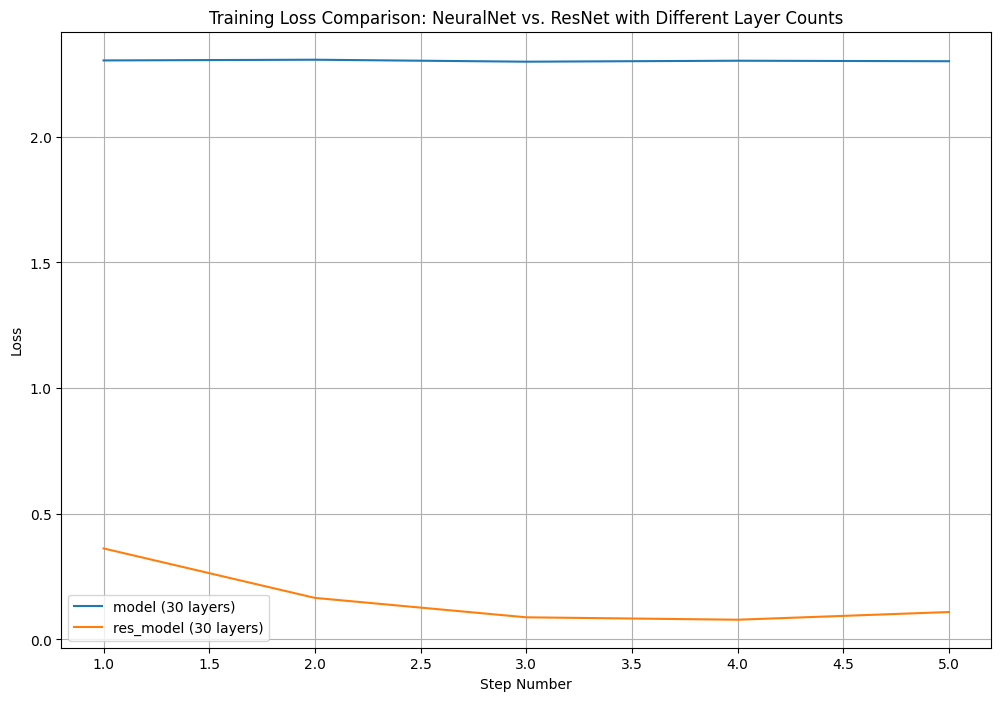

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.title("Training Loss Comparison: NeuralNet vs. ResNet with Different Layer Counts")
plt.xlabel("Step Number")
plt.ylabel("Loss")
plt.grid(True)

for model_type, num_layers, loss_data in model_layers_losses:
    if loss_data: # Ensure there is data to plot
        loss_values = [item[0] for item in loss_data]
        step_numbers = [item[1] for item in loss_data]
        plt.plot(step_numbers, loss_values, label=f'{model_type} ({num_layers} layers)')

plt.legend()
plt.show()

# Demonstrating Exploding Gradients in Res and Non Res Models

In [ ]:
## Layer wise output and plots of vanishing gradients
image,label = iter(test_loader).__next__()

(<matplotlib.image.AxesImage at 0x79916ca97020>,
 tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,

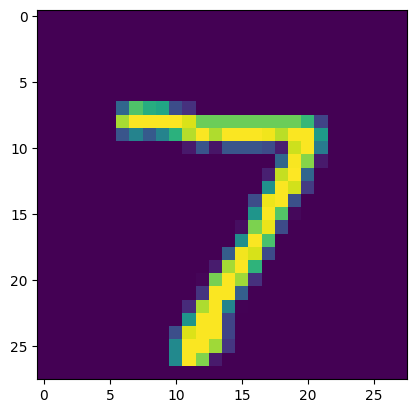

In [ ]:
plt.imshow(image[0][0]),image[0][0]

In [ ]:
img = image[0].view(1, -1).to(device)

In [ ]:
model(img),res_model(img)

(tensor([[-0.0117,  0.1127,  0.0079,  0.0185, -0.0286, -0.1068, -0.0165,  0.0562,
          -0.0252, -0.0297]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ -3.8718,   0.8324,   2.6225,   1.6497,  -2.0185,  -0.4083, -10.5619,
           16.0081,  -1.6284,   4.4134]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [ ]:
res_model,model

(ResNet(
   (first_linear): Linear(in_features=784, out_features=784, bias=True)
   (relu): ReLU()
   (residual_linear_layers): ModuleList(
     (0-48): 49 x Linear(in_features=784, out_features=784, bias=True)
   )
   (output_layer): Linear(in_features=784, out_features=10, bias=True)
 ),
 Ellipsis)

In [ ]:
layer(img)

tensor([[ 3.1836,  0.6688, -1.9711, -0.2135,  2.0120,  0.3002,  2.5948,  0.3068,
          1.1596,  2.6079]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
res_model.eval()
model.eval()

layer_outputs_res    = {}
layer_outputs_normal = {}
def hook_fn(name):
    def hook(module, input, output):
        layer_outputs_res[name] = output.detach()
    return hook

def hook_fn_normal(name):
    def hook_normal(module, input, output):
        layer_outputs_normal[name] = output.detach()
    return hook_normal


# Register hooks
for name, layer in model.named_modules():
    if isinstance(layer, (nn.Linear)):
        layer.register_forward_hook(hook_fn_normal(name))
for name, layer in res_model.named_modules():
    if isinstance(layer, (nn.Linear)):
        layer.register_forward_hook(hook_fn(name))

# Forward pass
_ = res_model(img)
_ = model(img)


In [ ]:
for name,layer in model.named_modules():
    print(name)
for name,layer in res_model.named_modules():
    print(name)



feature_extractor
feature_extractor.0
feature_extractor.1
feature_extractor.2
feature_extractor.3
feature_extractor.4
feature_extractor.5
feature_extractor.6
feature_extractor.7
feature_extractor.8
feature_extractor.9
feature_extractor.10
feature_extractor.11
feature_extractor.12
feature_extractor.13
feature_extractor.14
feature_extractor.15
feature_extractor.16
feature_extractor.17
feature_extractor.18
feature_extractor.19
feature_extractor.20
feature_extractor.21
feature_extractor.22
feature_extractor.23
feature_extractor.24
feature_extractor.25
feature_extractor.26
feature_extractor.27
feature_extractor.28
feature_extractor.29
feature_extractor.30
feature_extractor.31
feature_extractor.32
feature_extractor.33
feature_extractor.34
feature_extractor.35
feature_extractor.36
feature_extractor.37
feature_extractor.38
feature_extractor.39
feature_extractor.40
feature_extractor.41
feature_extractor.42
feature_extractor.43
feature_extractor.44
feature_extractor.45
feature_extractor.46
feat

In [ ]:
layer_outputs_res['residual_linear_layers.0'][:,:10], layer_outputs_normal['feature_extractor.0'][:,:10]

(tensor([[-0.5529, -1.1375, -1.3848,  1.1534, -1.0225, -0.6553, -3.2367, -1.5112,
          -4.2231, -2.4761]], device='cuda:0'),
 tensor([[-0.8526, -0.9872,  0.3279,  0.2939, -0.5937,  1.1905, -0.0786, -1.1868,
          -0.9270,  0.8690]], device='cuda:0'))

In [ ]:
layer_outputs_res['residual_linear_layers.10'][:,:10], layer_outputs_normal['feature_extractor.10'][:,:10]

(tensor([[-0.1882, -2.1936, -3.3562, -4.2530, -2.0414, -1.2654, -2.6386, -0.3698,
          -0.0404, -1.1813]], device='cuda:0'),
 tensor([[-0.0155,  0.0206,  0.0030,  0.0075, -0.0166,  0.0228,  0.0120,  0.0110,
           0.0269, -0.0320]], device='cuda:0'))

In [ ]:
layer_outputs_res['residual_linear_layers.20'][:,:10], layer_outputs_normal['feature_extractor.20'][:,:10]

(tensor([[-2.5106,  1.0196, -0.9177, -0.7142, -0.3174, -0.0122, -0.5805, -0.3575,
          -0.3656,  0.0699]], device='cuda:0'),
 tensor([[ 0.0211,  0.0017,  0.0240, -0.0469, -0.0208,  0.0056,  0.0045, -0.0110,
           0.0099, -0.0316]], device='cuda:0'))

In [ ]:
## calculate mean and std for each layer and plot the difference
## add layer norm to see the difference
for l in [0,6,10,16,20,26]:
    res_out = layer_outputs_res[f'residual_linear_layers.{l}']
    norm_out = layer_outputs_normal[f'feature_extractor.{l}']
    print(f"Layer {l}")
    print(f"Reslayer mean {res_out.mean()}, Non Res model mean {norm_out.mean()}")
    print(f"Reslayer std {res_out.std()}, Non Res model std {norm_out.std()}")

Layer 0
Reslayer mean -1.4245340824127197, Non Res model mean -0.015703026205301285
Reslayer std 1.074973225593567, Non Res model std 0.5048568248748779
Layer 6
Reslayer mean -1.6940349340438843, Non Res model mean 0.0016210059402510524
Reslayer std 1.2799965143203735, Non Res model std 0.038729228079319
Layer 10
Reslayer mean -1.6539545059204102, Non Res model mean -0.00014186426415108144
Reslayer std 1.3765727281570435, Non Res model std 0.023349294438958168
Layer 16
Reslayer mean -2.0087740421295166, Non Res model mean -0.0014653017278760672
Reslayer std 1.4467204809188843, Non Res model std 0.021433744579553604
Layer 20
Reslayer mean -1.1170098781585693, Non Res model mean -0.0005421487730927765
Reslayer std 0.9985248446464539, Non Res model std 0.021906975656747818
Layer 26
Reslayer mean -1.4488677978515625, Non Res model mean 0.00011450390593381599
Reslayer std 1.0992861986160278, Non Res model std 0.022849515080451965


In [ ]:
normal_model_weights

{}

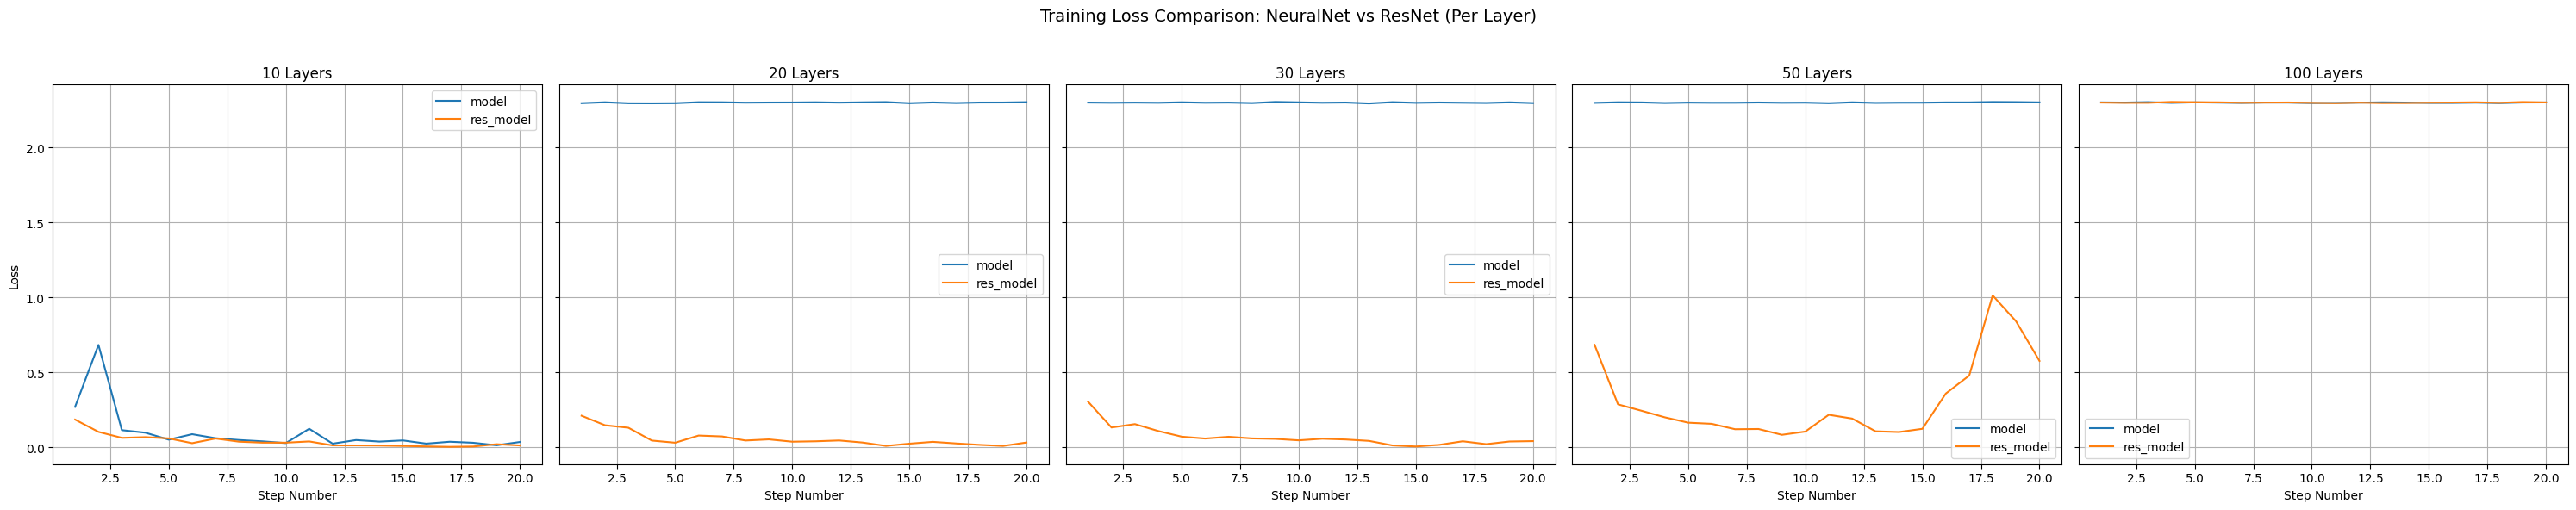

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Group data by number of layers
layer_groups = defaultdict(list)
for model_type, num_layers, loss_data in model_layers_losses:
    if loss_data:
        layer_groups[num_layers].append((model_type, loss_data))

num_layers_list = sorted(layer_groups.keys())
num_plots = len(num_layers_list)

fig, axes = plt.subplots(
    1, num_plots,
    figsize=(6 * num_plots, 6),
    sharey=True
)

# If only one subplot, make axes iterable
if num_plots == 1:
    axes = [axes]

for ax, num_layers in zip(axes, num_layers_list):
    for model_type, loss_data in layer_groups[num_layers]:
        loss_values = [item[0] for item in loss_data]
        step_numbers = [item[1] for item in loss_data]

        ax.plot(
            step_numbers,
            loss_values,
            label=model_type
        )

    ax.set_title(f"{num_layers} Layers")
    ax.set_xlabel("Step Number")
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel("Loss")
fig.suptitle(
    "Training Loss Comparison: NeuralNet vs ResNet (Per Layer)",
    fontsize=14
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# look into layers of model and res_model for an input and do some analysis

# ResNet vs Deepseek's MHC

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Hyperparameters
input_size = 784 # 28x28 for MNIST
hidden_size = 784 # Using a hidden size equal to input size for simplicity
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# 3. MNIST dataset loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image or numpy.ndarray to FloatTensor and scales values to [0, 1]
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize with mean and std dev for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 522kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.21MB/s]


In [ ]:
# ResNet model (with simple residual connections)
class ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=5): # num_blocks total linear layers
        super(ResNet, self).__init__()
        self.input_dim = input_dim

        # First layer (not a residual block): input_dim -> hidden_dim
        self.first_linear = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU() # Define ReLU once

        # Subsequent residual blocks: hidden_dim -> hidden_dim
        self.residual_linear_layers = nn.ModuleList()
        for _ in range(num_blocks - 1): # Create num_blocks-1 residual linear layers
            self.residual_linear_layers.append(nn.Linear(hidden_dim, hidden_dim))

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim) # Flatten the image

        # First layer
        x = self.first_linear(x)
        x = self.relu(x)

        # Residual layers
        for res_layer in self.residual_linear_layers:
            identity = x # Store input before the linear layer
            out = res_layer(x)
            x = self.relu(out + identity) # Add identity and then apply ReLU

        # Final output layer
        out = self.output_layer(x)
        return out

In [ ]:
### hyper connections vs ResNets

class HyperConnection_Block(nn.Module):
    def __init__(self, hidden_dim, num_hyperconstraints = 4):
        super(HyperConnection_Block, self).__init__()
        projected_dim =hidden_dim*num_hyperconstraints
        self.H_res_l  = nn.Linear(projected_dim, projected_dim)
        self.H_pre_l  = nn.Linear(projected_dim,hidden_dim)
        self.FFN      = nn.Sequential(
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU()
        )
        self.H_post_l = nn.Linear(hidden_dim,projected_dim)


    def forward(self, x):
        hl_res = self.H_res_l(x)
        x = self.H_pre_l(x)
        x = self.FFN(x)
        x = self.H_post_l(x)

        return x + hl_res

class HyperConnections(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=5, num_hyperconstraints = 4): # num_blocks total linear layers
        super(HyperConnections, self).__init__()
        self.input_dim = input_dim

        self.first_linear = nn.Linear(input_dim, hidden_dim*num_hyperconstraints)

        # Subsequent residual blocks: hidden_dim -> hidden_dim
        self.hyperconnections = nn.ModuleList()
        for _ in range(num_blocks): # Create num_blocks-1 residual linear layers
            self.hyperconnections.append(HyperConnection_Block(hidden_dim,num_hyperconstraints))

        self.output_layer = nn.Linear(hidden_dim*num_hyperconstraints, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim) # Flatten the image

        # First layer
        x = self.first_linear(x)

        # Residual layers
        for hc in self.hyperconnections:
            x = hc(x)

        # Final output layer
        out = self.output_layer(x)
        return out

In [ ]:
def train(model, epochs = num_epochs):
    # 5. Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    print(f"\nStarting training for {model.__class__.__name__}...")
    for epoch in range(epochs):
        model.train() # Set the model to training mode
        avg_loss = 0
        count = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                # print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                count+=1
                avg_loss += loss.item()
        losses.append((avg_loss/(max(1,count)),epoch+1))

    print("Training complete.")

    # 7. Test the model
    print("\nTesting model performance...")
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the {model.__class__.__name__} on the 10000 test images: {100 * correct / total:.2f}%')
    return losses

In [ ]:
model_layers_losses = []  ## model type, num layers, their losses
experiments = [10,50,100]
epochs = 30
for layers in experiments:
    res_model = ResNet(input_size, hidden_size, num_classes,num_blocks=layers).to(device)
    hyperconnections = HyperConnections(input_size,hidden_size,num_classes,num_blocks=layers).to(device)
    res_loss   = train(res_model,epochs)
    hc_loss    = train(hyperconnections)
    model_layers_losses.append(("res_model", layers, res_loss))
    model_layers_losses.append(("hyperconnections", layers, hc_loss))



Starting training for ResNet...
Training complete.

Testing model performance...
Accuracy of the ResNet on the 10000 test images: 97.81%

Starting training for HyperConnections...
Training complete.

Testing model performance...
Accuracy of the HyperConnections on the 10000 test images: 8.67%

Starting training for ResNet...
Training complete.

Testing model performance...
Accuracy of the ResNet on the 10000 test images: 91.70%

Starting training for HyperConnections...


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 2733 has 14.73 GiB memory in use. Of the allocated memory 14.22 GiB is allocated by PyTorch, and 380.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# FineTuning Models on Code to make Claude Code
1. Coding Tasks
2. Agentic Tasks
3. Reasoning Tasks think token  --> Done
4. Long context sizes (1M token extension) for this implement RoPE and YaRN
5. Model Distillation   --> Done
6. RLHF using KL Divergence --> Take above model to score output and do RLHF for new images

In [ ]:
# Model Distillation on ResNet(50 layer large model) + NN (20 layer small model)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Hyperparameters
input_size = 784 # 28x28 for MNIST
hidden_size = 784 # Using a hidden size equal to input size for simplicity
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# 3. MNIST dataset loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image or numpy.ndarray to FloatTensor and scales values to [0, 1]
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize with mean and std dev for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 4. Neural Network model (without residual connections)
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_intermediate_blocks=4):
        super(NeuralNet, self).__init__()
        self.input_dim = input_dim
        layers = []
        # First layer: input_dim -> hidden_dim
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        # Intermediate layers: hidden_dim -> hidden_dim
        for _ in range(num_intermediate_blocks):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim) # Flatten the image
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

# ResNet model (with simple residual connections)
class ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=5): # num_blocks total linear layers
        super(ResNet, self).__init__()
        self.input_dim = input_dim

        # First layer (not a residual block): input_dim -> hidden_dim
        self.first_linear = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU() # Define ReLU once

        # Subsequent residual blocks: hidden_dim -> hidden_dim
        self.residual_linear_layers = nn.ModuleList()
        for _ in range(num_blocks - 1): # Create num_blocks-1 residual linear layers
            self.residual_linear_layers.append(nn.Linear(hidden_dim, hidden_dim))

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim) # Flatten the image

        # First layer
        x = self.first_linear(x)
        x = self.relu(x)

        # Residual layers
        for res_layer in self.residual_linear_layers:
            identity = x # Store input before the linear layer
            out = res_layer(x)
            x = self.relu(out + identity) # Add identity and then apply ReLU

        # Final output layer
        out = self.output_layer(x)
        return out

# # Instantiate models
# model = NeuralNet(input_size, hidden_size, num_classes).to(device)
# res_model = ResNet(input_size, hidden_size, num_classes).to(device)

# Define a training function to avoid code duplication
def train(model, epochs = num_epochs):
    # 5. Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    print(f"\nStarting training for {model.__class__.__name__}...")
    for epoch in range(epochs):
        model.train() # Set the model to training mode
        avg_loss = 0
        count = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                # print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                count+=1
                avg_loss += loss.item()
        losses.append((avg_loss/(max(1,count)),epoch+1))

    print("Training complete.")

    # 7. Test the model
    print("\nTesting model performance...")
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the {model.__class__.__name__} on the 10000 test images: {100 * correct / total:.2f}%')
    return losses

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 19.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.3MB/s]


In [ ]:
## First train ResNet, NeuralNet
NN_layers = 20
res_layers = 50
model = NeuralNet(input_size, hidden_size, num_classes,num_intermediate_blocks=NN_layers-1).to(device)
res_model = ResNet(input_size, hidden_size, num_classes,num_blocks=res_layers).to(device)

In [ ]:
print("**Training NeuralNetModel**")
train(model,20)
print("**Training ResNet Model**")
train(res_model,20)

**Training NeuralNetModel**

Starting training for NeuralNet...
Training complete.

Testing model performance...
Accuracy of the NeuralNet on the 10000 test images: 11.35%
**Training ResNet Model**

Starting training for ResNet...
Training complete.

Testing model performance...
Accuracy of the ResNet on the 10000 test images: 80.27%


[(0.8548586567242941, 1),
 (0.24113325277964273, 2),
 (0.15146990079018804, 3),
 (0.18146152049303055, 4),
 (0.11511296985877885, 5),
 (0.19986322563555506, 6),
 (0.13249058317806986, 7),
 (0.1193762897617287, 8),
 (0.14624066982004377, 9),
 (0.17902556972371209, 10),
 (0.14814752754237917, 11),
 (0.10890610929992464, 12),
 (0.2408033325854275, 13),
 (0.5968615015347799, 14),
 (0.7945286499129401, 15),
 (1.3962786727481418, 16),
 (0.9909177223841349, 17),
 (0.837208542558882, 18),
 (1.236028300391303, 19),
 (0.9008315669165717, 20)]

In [ ]:
def kl_divergence_loss(P, Q):
    return P * (torch.log_softmax(P)/torch.softmax(Q))
    return  torch.sum(P * torch.log(P/Q))

TypeError: log_softmax() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype = None, *, Tensor out = None)
 * (Tensor input, name dim, *, torch.dtype dtype = None)


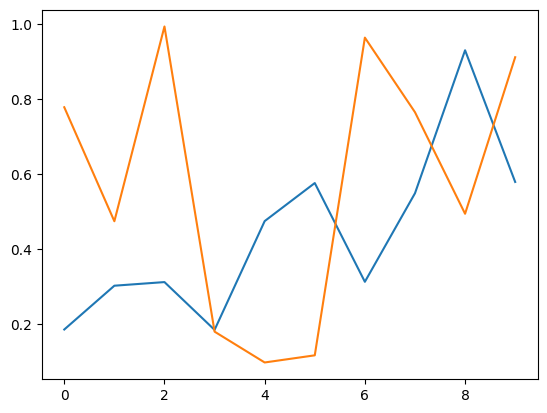

In [ ]:
import matplotlib.pyplot as plt
plt.plot(P[0])
plt.plot(Q[0])
plt.plot(kl_divergence_loss(P,Q))

In [ ]:
P,Q = torch.rand(1,10),torch.rand(1,10)
D = kl_divergence_loss(P,Q)
P,Q,D

TypeError: log_softmax() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype = None, *, Tensor out = None)
 * (Tensor input, name dim, *, torch.dtype dtype = None)


In [ ]:
P, torch.log_softmax(P)

In [ ]:
import torch.nn.functional as F
def kl_divergence_loss(teacher, student, T = 4):
    student_logits = F.log_softmax(student/ T, 1)
    teacher_logits = F.log_softmax(teacher/ T, 1)
    teacher_probs  = F.softmax(teacher/ T, 1)
    return torch.mean(teacher_probs * (teacher_logits - student_logits))

In [ ]:
## Train NeuralNet using distillation
def train_distill(model, parent, epochs = num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    alpha = 0.5
    T = 4
    losses = []
    parent.eval()
    print(f"\nStarting training for {model.__class__.__name__}...")
    for epoch in range(epochs):
        model.train() # Set the model to training mode
        avg_loss = 0
        count = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            with torch.no_grad():
                parent_outputs = parent(images)
            loss = alpha * criterion(outputs, labels) + (1-alpha) * kl_divergence_loss(outputs, parent_outputs, T) * T * T

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                # print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                count+=1
                avg_loss += loss.item()
        losses.append((avg_loss/(max(1,count)),epoch+1))

    print("Training complete.")

    # 7. Test the model
    print("\nTesting model performance...")
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the {model.__class__.__name__} on the 10000 test images: {100 * correct / total:.2f}%')
    return losses

In [ ]:
distill_model = NeuralNet(input_size, hidden_size, num_classes,num_intermediate_blocks=NN_layers-1).to(device)

In [ ]:
small_distill_model = NeuralNet(input_size, hidden_size, num_classes,num_intermediate_blocks=NN_layers-10).to(device)

In [ ]:
train_distill(small_distill_model, res_model, 20)


Starting training for NeuralNet...
Training complete.

Testing model performance...
Accuracy of the NeuralNet on the 10000 test images: 97.03%


[(0.4189869778023826, 1),
 (0.14398070259226692, 2),
 (0.13080218765470716, 3),
 (0.12263627764251497, 4),
 (0.11045563220977783, 5),
 (0.11906235251161787, 6),
 (0.10477561420864528, 7),
 (0.12974303629663256, 8),
 (0.13114537215895122, 9),
 (0.10365178974138366, 10),
 (0.09147246678670247, 11),
 (0.0935981600648827, 12),
 (0.07867759548955494, 13),
 (0.08768310397863388, 14),
 (0.09305381402373314, 15),
 (0.09255875978204939, 16),
 (0.10391622285048167, 17),
 (0.0874728796382745, 18),
 (0.08058628439903259, 19),
 (0.0876816035144859, 20)]

In [ ]:
for images, labels in test_loader:
    print("labels\n", labels)
    print("\n\nresModel\n",torch.max(res_model(images.to(device)),1)[1])
    print("\n\ndistillModel\n",torch.max(distill_model(images.to(device)),1)[1])
    print("\n\nsmalldistillModel\n",torch.max(small_distill_model(images.to(device)),1)[1])
    print("\n\nModel\n",torch.max(model(images.to(device)),1)[1])
    break

labels
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


resModel
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 0, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 9, 4, 0, 1, 3, 1, 3, 0, 7, 2, 9, 1, 2, 1, 1, 9, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 0, 0, 4, 1, 9, 8, 7, 3, 9, 1], device='cuda:0')


distillModel
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 5, 7, 2, 7, 1, 2, 1, 1, 7, 4, 1, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 8, 3], device='cuda:0')


smalldistillModel
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')


Model
 tensor([1, 1, 1

In [ ]:
images.shape

torch.Size([64, 1, 28, 28])

In [ ]:
torch.max(res_model(images.to(device)),1)[1]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 0, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 9, 4, 0, 1, 3, 1, 3, 0, 7, 2, 9, 1, 2, 1, 1, 9, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 0, 0, 4, 1, 9, 8, 7, 3, 9, 1], device='cuda:0')

In [ ]:
### Observation
#Distill model outperforms resmodel --> reason distill model doesn't start from scratch it starts with res_model's learning + gets trained on data
## Even without resnet connections small model was outperforming all the models

In [ ]:
### KL Divergence   --> Q * log(P/Q) --> softmax(Q) * (log_softmax(P) - logsoftmax(Q))
### Cross Entropy Loss -> -yi * e(sum(yi))
###
###
###

## KL Divergence on LLMs
### Train NonCode SLM to Code

In [ ]:
## Qwen 3 0.6 B --> Quantized model  --> Qwen/Qwen3-0.6B
## Qwen/Qwen3-1.7B
## Dataset

In [ ]:
!pip install -U bitsandbytes

In [ ]:
torch.cuda.is_available()

False

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytes
from datasets import load_dataset
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dataset = load_dataset("openai/gsm8k", "main")

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})

In [ ]:
dataset['train']['answer']

Column(['Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72', 'Weng earns 12/60 = $<<12/60=0.2>>0.2 per minute.\nWorking 50 minutes, she earned 0.2 x 50 = $<<0.2*50=10>>10.\n#### 10', "In the beginning, Betty has only 100 / 2 = $<<100/2=50>>50.\nBetty's grandparents gave her 15 * 2 = $<<15*2=30>>30.\nThis means, Betty needs 100 - 50 - 30 - 15 = $<<100-50-30-15=5>>5 more.\n#### 5", 'Maila read 12 x 2 = <<12*2=24>>24 pages today.\nSo she was able to read a total of 12 + 24 = <<12+24=36>>36 pages since yesterday.\nThere are 120 - 36 = <<120-36=84>>84 pages left to be read.\nSince she wants to read half of the remaining pages tomorrow, then she should read 84/2 = <<84/2=42>>42 pages.\n#### 42', 'He writes each friend 3*2=<<3*2=6>>6 pages a week\nSo he writes 6*2=<<6*2=12>>12 pages every week\nThat means he writes 12*52=<<12*52=624>>624 pages a year\n#### 624'])

In [ ]:
student = "Qwen/Qwen3-0.6B"
student_model = AutoModelForCausalLM.from_pretrained(student)
tokenizer = AutoTokenizer.from_pretrained(student)

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [ ]:
teacher = "Qwen/Qwen3-1.7B"

### Testing before model distillation

In [ ]:
def merge_ques_ans(example):
    return f"""**Question**\n{example["question"]}\n**Answer**\n{example["answer"]}"""
def format_ques(example):
     return f"""**Question**\n{example["question"]}\n**Answer**\n"""

In [ ]:
for i in dataset['test'].take(2):
    text =  format_ques(i)
    # tokens = tokenizer(text, return_tensors = "pt").to(device)
    # output = student_model(**tokens)
    # print(output.logits)
    print("Generated Content")
    print(tokenizer.decode(student_model.generate(**tokenizer(text,return_tensors = "pt"),max_new_tokens = 100)[0],skip_special_tokens = True))
    print(f"\nActual Content\n{i["answer"]}")

Generated Content
**Question**
Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
**Answer**
**A**
**B**
**C**
**D**
**E**
**Answer:**
**A**
**B**
**C**
**D**
**E**

**Question**
**Answer:**
**A**
**B**
**C**
**D**
**E**
**Question**
**Answer:**
**A**
**B**
**C**
**D**
**E**
**Question**
**Answer:**
**A**
**B**
**C**
**D**
**E**


Actual Content
Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18
Generated Content
**Question**
A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
**Answer**
**A**
**B**
**C**
**D**
**E**
**A**
**B**
**C**
**D**
**E**

**Question**
A man has a certain amount of money. He spends 30% of his money on a c

## RLHF

In [ ]:
###  Anthropic/hh-rlhf

# Small MoEs vs FFN models
1. Just FFN
2. Test with Attention
3. MoMEs Deepseek shared expert
3. Do Distributed training of MoEs on multiple GPUs

In [3]:
## Take a 10M param FFN vs 10M_A1M MoEs
import torch
import torch.nn as nn

In [24]:
class FFN_Block(nn.Module):
    def __init__(self,
                 embed_dim,
                 hidden_dim,
                 dropout = 0,
                 activation = "ReLU"):
        super().__init__()
        self.activation = {"ReLU": nn.ReLU(), "GELU": nn.GELU()}
        self.model = nn.Sequential(
            nn.Linear(embed_dim,hidden_dim),
            self.activation[activation],
            nn.Linear(hidden_dim,embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.model(x)

class FFN(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 embed_dim,
                 hidden_dim,
                 num_hidden_layers,
                 dropout,
                 layernorm_eps,
                 activation = "ReLU",
                 residual = False
                 ):
        super().__init__()
        self.num_hidden_layers = num_hidden_layers
        self.residual = residual
        self.input_ffn =  nn.Linear(input_dim,embed_dim)
        self.ffn = nn.ModuleList([FFN_Block(embed_dim,hidden_dim,dropout,activation) for _ in range(num_hidden_layers)])
        self.layernorm = nn.ModuleList([nn.LayerNorm(embed_dim,eps = layernorm_eps) for _ in range(num_hidden_layers)])
        self.out = nn.Linear(embed_dim,output_dim)
    def forward(self, x):
        x = self.input_ffn(x)
        for i in range(self.num_hidden_layers):
            residual = x
            x = self.layernorm[i](x)
            x = self.ffn[i](x)
            if self.residual:
                x = x + residual
        return self.out(x)

In [11]:
def calculate_parameters(model):
    total_params = 0
    trainable_params = 0
    for _,j in model.named_parameters():
        if j.requires_grad: # Corrected from j.required_grad
            trainable_params+= j.numel()
        total_params+= j.numel()
    print(f"Total : {total_params}, trainable : {trainable_params}, percentage of trainable {(trainable_params/total_params)*100:.2f}%, model_size = {total_params/1_000_000}M parameters")


In [25]:
input_dim  = 784
output_dim = 10
embed_dim = 896
hidden_dim  =896*4
num_hidden_layers = 40
dropout = 0.1
layernorm_eps = 0.1
activation = "ReLU"
feedforward = FFN(input_dim,
                  output_dim,
                 embed_dim,
                 hidden_dim,
                 num_hidden_layers,
                 dropout,
                 layernorm_eps,
                 activation,
                  residual=True)

In [26]:
calculate_parameters(feedforward)

Total : 257864330, trainable : 257864330, percentage of trainable 100.00%, model_size = 257.86433M parameters


## Load Data

In [5]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Hyperparameters
input_size = 784 # 28x28 for MNIST
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# 3. MNIST dataset loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image or numpy.ndarray to FloatTensor and scales values to [0, 1]
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize with mean and std dev for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


In [6]:
def train(model, epochs = num_epochs):
    # 5. Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    print(f"\nStarting training for {model.__class__.__name__}...")
    for epoch in range(epochs):
        model.train() # Set the model to training mode
        avg_loss = 0
        count = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 500 == 0:
                print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                count+=1
                avg_loss += loss.item()
        losses.append((avg_loss/(max(1,count)),epoch+1))

    print("Training complete.")

    # 7. Test the model
    print("\nTesting model performance...")
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the {model.__class__.__name__} on the 10000 test images: {100 * correct / total:.2f}%')
    return losses


In [14]:
train(feedforward.to(device),10)


Starting training for FFN...
Epoch [1/10], Step [500/938], Loss: 0.3230
Epoch [2/10], Step [500/938], Loss: 0.0930
Epoch [3/10], Step [500/938], Loss: 0.0893
Epoch [4/10], Step [500/938], Loss: 0.0482
Epoch [5/10], Step [500/938], Loss: 0.0323
Epoch [6/10], Step [500/938], Loss: 0.0322
Epoch [7/10], Step [500/938], Loss: 0.0527
Epoch [8/10], Step [500/938], Loss: 0.2566
Epoch [9/10], Step [500/938], Loss: 0.2813
Epoch [10/10], Step [500/938], Loss: 0.0334
Training complete.

Testing model performance...
Accuracy of the FFN on the 10000 test images: 97.36%


[(0.32297950983047485, 1),
 (0.09302851557731628, 2),
 (0.08927194774150848, 3),
 (0.048225678503513336, 4),
 (0.03233182802796364, 5),
 (0.03218984603881836, 6),
 (0.052694015204906464, 7),
 (0.2565698027610779, 8),
 (0.28134840726852417, 9),
 (0.033393438905477524, 10)]

In [14]:
input_dim  = 784
output_dim = 10
embed_dim = 512
hidden_dim  =2048
num_hidden_layers = 5
dropout = 0.1
layernorm_eps = 0.1
activation = "GELU"
feedforward_res = FFN(input_dim,
                  output_dim,
                 embed_dim,
                 hidden_dim,
                 num_hidden_layers,
                 dropout,
                 layernorm_eps,
                 activation,
                  residual = True)
train(feedforward_res,10)

In [9]:
class FFN_Block(nn.Module):
    def __init__(self,
                 embed_dim,
                 hidden_dim,
                 dropout=0,
                 activation="ReLU"):
        super().__init__()
        activations = {"ReLU": nn.ReLU(), "GELU": nn.GELU()}
        self.model = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            activations[activation],
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.model(x)
class MoE_FFN_Block(nn.Module):
    def __init__(self,
                 embed_dim,
                 hidden_dim,
                 num_experts,
                 dropout=0,
                 activation="ReLU"):
        super().__init__()
        self.num_experts = num_experts

        # Experts
        self.experts = nn.ModuleList([
            FFN_Block(embed_dim, hidden_dim, dropout, activation)
            for _ in range(num_experts)
        ])

        # Gating network
        self.gate = nn.Linear(embed_dim, num_experts)

    def forward(self, x):
        """
        x: (batch, embed_dim)
        """
        # 1. Compute gate scores
        gate_logits = self.gate(x)                  # (batch, num_experts)
        gate_weights = torch.softmax(gate_logits, dim=-1)

        # 2. Expert outputs
        expert_outputs = torch.stack(
            [expert(x) for expert in self.experts],
            dim=1                                    # (batch, num_experts, embed_dim)
        )

        # 3. Weighted sum
        gate_weights = gate_weights.unsqueeze(-1)   # (batch, num_experts, 1)
        output = torch.sum(gate_weights * expert_outputs, dim=1)

        return output
class MoE_FFN(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 embed_dim,
                 hidden_dim,
                 num_hidden_layers,
                 num_experts,
                 dropout,
                 layernorm_eps,
                 activation="ReLU",
                 residual=False):
        super().__init__()

        self.num_hidden_layers = num_hidden_layers
        self.residual = residual

        self.input_ffn = nn.Linear(input_dim, embed_dim)

        self.moe_layers = nn.ModuleList([
            MoE_FFN_Block(
                embed_dim=embed_dim,
                hidden_dim=hidden_dim,
                num_experts=num_experts,
                dropout=dropout,
                activation=activation
            )
            for _ in range(num_hidden_layers)
        ])

        self.layernorms = nn.ModuleList([
            nn.LayerNorm(embed_dim, eps=layernorm_eps)
            for _ in range(num_hidden_layers)
        ])

        self.out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.input_ffn(x)

        for i in range(self.num_hidden_layers):
            residual = x
            x = self.layernorms[i](x)
            x = self.moe_layers[i](x)
            if self.residual:
                x = x + residual

        return self.out(x)
model = MoE_FFN(
    input_dim=input_dim,
    output_dim=output_dim,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_hidden_layers=num_hidden_layers,
    num_experts=4,        # 👈 MoE magic
    dropout=0.1,
    layernorm_eps=1e-5,
    activation="GELU",
    residual=True
)


In [12]:
calculate_parameters(model)

Total : 42416670, trainable : 42416670, percentage of trainable 100.00%, model_size = 42.41667M parameters


In [24]:
def train(model, epochs = num_epochs):
    # 5. Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    print(f"\nStarting training for {model.__class__.__name__}...")
    for epoch in range(epochs):
        model.train() # Set the model to training mode
        avg_loss = 0
        count = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 500 == 0:
                print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                count+=1
                avg_loss += loss.item()
        losses.append((avg_loss/(max(1,count)),epoch+1))

    print("Training complete.")

    # 7. Test the model
    print("\nTesting model performance...")
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the {model.__class__.__name__} on the 10000 test images: {100 * correct / total:.2f}%')
    return losses


In [ ]:
train(model.to(device),10)

In [22]:
print("\nTesting model performance...")
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the {model.__class__.__name__} on the 10000 test images: {100 * correct / total:.2f}%')


Testing model performance...
Accuracy of the MoE_FFN on the 10000 test images: 95.30%


In [17]:
large_moe = MoE_FFN(
    input_dim=input_dim,
    output_dim=output_dim,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_hidden_layers=num_hidden_layers*16,
    num_experts=8,        # 👈 MoE magic
    dropout=0.1,
    layernorm_eps=1e-5,
    activation="GELU",
    residual=True
)
calculate_parameters(large_moe)

Total : 1344632970, trainable : 1344632970, percentage of trainable 100.00%, model_size = 1344.63297M parameters


In [23]:
def compare_latency_of_models(model_list, device = "cpu", num_steps = 5, warmup_steps = 2):
    import time
    import gc
    latencies = []
    flops = []
    for model in model_list:
        model = model.to(device)
        for i in range(warmup_steps):
            model.eval() # Set the model to evaluation mode
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.view(images.size(0), -1).to(device)
                    model(images)
        start = time.time()
        for i in range(num_steps):
            model.eval() # Set the model to evaluation mode
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.view(images.size(0), -1).to(device)
                    model(images)
        latencies.append(time.time()-start)
        del model
        torch.cuda.empty_cache()
        gc.collect()
    return latencies

In [24]:
compare_latency_of_models([feedforward,model],device)

[29.79228401184082, 59.82702660560608]

In [27]:
calculate_parameters(feedforward),calculate_parameters(model),calculate_parameters(large_moe)

Total : 257864330, trainable : 257864330, percentage of trainable 100.00%, model_size = 257.86433M parameters
Total : 42416670, trainable : 42416670, percentage of trainable 100.00%, model_size = 42.41667M parameters
Total : 1344632970, trainable : 1344632970, percentage of trainable 100.00%, model_size = 1344.63297M parameters


(None, None, None)

In [22]:
# !pip install fvcore
def calculate_flops(model_list,device = "cpu"):
    from fvcore.nn import FlopCountAnalysis
    flops = []
    for model in model_list:
        model.eval()
        model.to(device)

        images,_ = next(iter(test_loader))

        flop = FlopCountAnalysis(model,  images.view(images.size(0), -1).to(device))
        print(f"Total FLOPs: {flop.total()/1_000_000_000_000}T")
        flops.append(flop)
    return flops


In [ ]:
flops = calculate_flops([feedforward,large_moe])

Total FLOPs: 0.016498671616T


In [23]:
flops = calculate_flops([model,large_moe],device)

Total FLOPs: 0.002711846912T


Total FLOPs: 0.085959442432T


# Utils

## Data Loading Utils
1. Class to load any data
2. Return Encoded and decoded data

## All Model Utils
1. Class containing all types of layers like FFN, MoEs, etc
2. Return Model with choosen layers

## Train Tokenization